## Libraries

In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

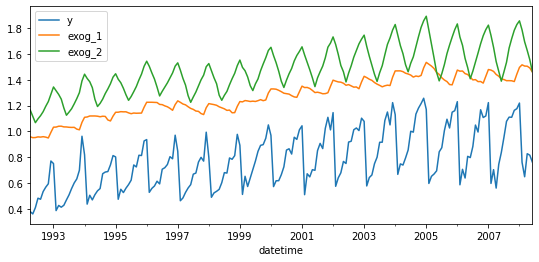

In [6]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [7]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

## Train forecaster

In [8]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 15
                )

forecaster.fit(
    y    = data_train['y'],
    exog = data_train[['exog_1', 'exog_2']]
)

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-07 21:15:22 
Last fit date: 2021-12-07 21:15:22 
Skforecast version: 0.4.0 

## Prediction

If the `Forecaster` has been trained with exogenous variables, they shlud be provided when predictiong.

In [9]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['exog_1', 'exog_2']]
               )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

datetime
2005-07-01    0.908832
2005-08-01    0.953925
2005-09-01    1.100887
Freq: MS, Name: pred, dtype: float64

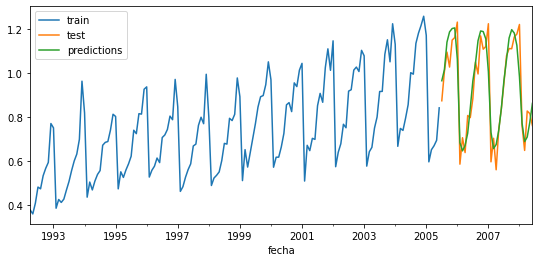

In [7]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [10]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004022228812838391


## Feature importance

In [15]:
print(forecaster.get_feature_importance().to_markdown(index=False))

| feature   |   importance |
|:----------|-------------:|
| lag_1     |   0.0133541  |
| lag_2     |   0.0611202  |
| lag_3     |   0.00908617 |
| lag_4     |   0.00272094 |
| lag_5     |   0.00247847 |
| lag_6     |   0.00315493 |
| lag_7     |   0.00217887 |
| lag_8     |   0.00815443 |
| lag_9     |   0.0103189  |
| lag_10    |   0.0205869  |
| lag_11    |   0.00703555 |
| lag_12    |   0.773389   |
| lag_13    |   0.00458297 |
| lag_14    |   0.0181272  |
| lag_15    |   0.00873237 |
| exog_1    |   0.0103638  |
| exog_2    |   0.0446156  |


## Extract training matrix

In [10]:
X, y = forecaster.create_train_X_y(
            y    = data_train['y'],
            exog = data_train[['exog_1', 'exog_2']].values
        )